In [10]:
# Imports, as always...
import os
import re
import csv
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn as nn
from torch.utils.data import DataLoader

from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss

from tqdm.notebook import tqdm

from data_handling import ISICDataset
from models.hopfield_restoration import build_hopfield_restoration_block
from models.image_segmentation import SegmentationModel

from datetime import datetime

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Spectral')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.set_default_device('cuda')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

print(f'Date: {date_string}')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121
Date: 2024-03-17-(21-17-34)


/home/benprie/miniconda3/envs/mlp-project-wsl/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


## Data Handling

In [10]:
# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

## Segmentation, and Whatnot

In [2]:
# Demonstrate model's segmentation.
def side_by_side_model_segmentation(model, example_sample, cmap='bone'):
    # Break apart the sample and move to device.
    example_input, example_target = example_sample
    example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
    example_target = example_target.to('cuda')
    example_output, _ = model(example_input, example_target)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
    ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
    ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)
    
    # Memory saving.
    del example_sample
    del example_input
    del example_target
    del example_output
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Corrupted Input')
    ax2.set_title('Predicted Mask')
    ax3.set_title('True Mask')

In [11]:
# Define the model.
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.model = UnetPlusPlus(
            encoder_name='timm-efficientnet-b0',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self, x, y_true):
        y_pred = self.model(x)
        
        if y_true is not None:
            loss = DiceLoss(mode='binary')(y_pred, y_true)
            return y_pred, loss
        
        return y_pred
    
model = SegmentationModel()
model = model.to('cuda')

In [ ]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for inputs, targets in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        
        optimiser.zero_grad()
        y_pred, loss = model(inputs, targets)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            val_loss += loss.item()
            
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(model, train_dataloader, optimiser)
    val_loss = test(model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./models/unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()

## Segmentation on Damaged Data

In [7]:
model = SegmentationModel()
model = model.to('cuda')

# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

In [ ]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for inputs, targets in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        
        optimiser.zero_grad()
        y_pred, loss = model(inputs, targets)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            val_loss += loss.item()
            
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(model, train_dataloader, optimiser)
    val_loss = test(model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./models/unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()

## Comparing the Models

In [2]:
# Fully-trained U-Net for clean data: 2024-03-14-(17-17-31)
clean_model_stats = pd.read_csv('./models/unet/saves/2024-03-14-(17-17-31)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
clean_model_stats['Epoch'] = clean_model_stats['Epoch'] + 1

# Fully-trained U-Net for 25% uniformly randomly corrupted data: 2024-03-14-(12-48-12)
damaged_model_stats = pd.read_csv('./models/unet/saves/2024-03-14-(12-48-12)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
damaged_model_stats['Epoch'] = damaged_model_stats['Epoch'] + 1

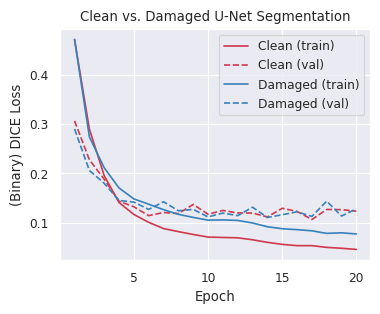

In [3]:
# Plot those losses, eh
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

colours = sns.color_palette('Spectral', n_colors=10)

sns.lineplot(data=clean_model_stats, x='Epoch', y='Train loss', linestyle='-', color=colours[0], ax=ax, label='Clean (train)')
sns.lineplot(data=clean_model_stats, x='Epoch', y='Val loss', linestyle='--', color=colours[0], ax=ax, label='Clean (val)')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Train loss', linestyle='-', color=colours[-1], ax=ax, label='Damaged (train)')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Val loss', linestyle='--', color=colours[-1], ax=ax, label='Damaged (val)')

ax.set_ylabel('(Binary) DICE Loss')
ax.set_title('Clean vs. Damaged U-Net Segmentation')

plt.savefig('./misc-figures/clean-vs-damaged-unit-loss-curves.pdf', bbox_inches='tight')

<Axes: xlabel='Epoch', ylabel='Val loss'>

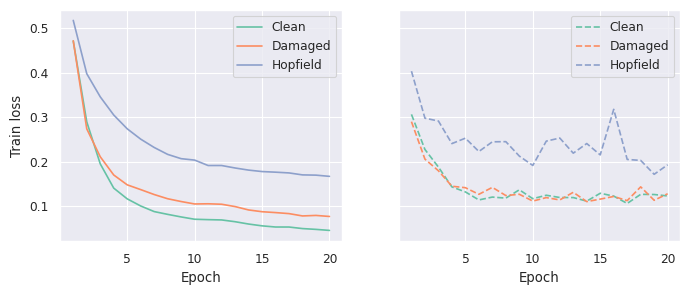

In [18]:
hopfield_model_stats = pd.read_csv('./models/hopfield-unet/saves/2024-03-15-(02-26-15)/stats.csv', header=None).rename(columns={0 : 'Epoch', 1 : 'Train loss', 2 : 'Val loss'})
hopfield_model_stats['Epoch'] = hopfield_model_stats['Epoch'] + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey='all')

sns.set_palette('Set2', n_colors=11)
sns.lineplot(data=clean_model_stats, x='Epoch', y='Train loss', linestyle='-', ax=ax1, label='Clean')
sns.lineplot(data=clean_model_stats, x='Epoch', y='Val loss', linestyle='--', ax=ax2, label='Clean')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Train loss', linestyle='-', ax=ax1, label='Damaged')
sns.lineplot(data=damaged_model_stats, x='Epoch', y='Val loss', linestyle='--', ax=ax2, label='Damaged')
sns.lineplot(data=hopfield_model_stats, x='Epoch', y='Train loss', linestyle='-', ax=ax1, label='Hopfield')
sns.lineplot(data=hopfield_model_stats, x='Epoch', y='Val loss', linestyle='--', ax=ax2, label='Hopfield')

### How much performance does the clean model lose when tested on damaged data?

In [11]:
# Fully-trained U-Net for clean data: 2024-03-14-(17-17-31)
clean_model = SegmentationModel()
clean_model.load_state_dict(torch.load('./models/unet/saves/2024-03-14-(17-17-31)/model-state-dict.pt'))

<All keys matched successfully>

In [2]:
# Evaluating a given model on a given dataloader.
def test(model, test_loader, hopfield_layer=None):
    model.eval()
    test_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            if hopfield_layer is not None:
                inputs = hopfield_layer(inputs)
            
            _, loss = model(inputs, targets)
            test_loss += loss.item()
            
            # Memory saving.
            del inputs
            del targets
            del loss
            
        return test_loss / len(test_loader)

In [ ]:
# Performance of clean model on different degrees of damage.
damage_degrees = [0, .10, .25, .50, .95]

for damage_degree in tqdm(damage_degrees):
    # Train.
    train_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Training_Input',
        target_path='ISIC2018_Task1_Training_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    train_performance = test(clean_model, train_dataloader)
    
    del train_dataset
    del train_dataloader
    
    # Validation.
    val_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Validation_Input',
        target_path='ISIC2018_Task1_Validation_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    val_performance = test(clean_model, val_dataloader)
    
    del val_dataset
    del val_dataloader
    
    # Test.
    test_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Test_Input',
        target_path='ISIC2018_Task1_Test_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    test_performance = test(clean_model, test_dataloader)
    
    del test_dataset
    del test_dataloader
    
    # Write stats to file.
    with open(f'./models/unet/saves/2024-03-14-(17-17-31)/damage-performance.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([damage_degree, train_performance, val_performance, test_performance])

    print(f'Damage degree - {damage_degree}: train - {train_performance}, val - {val_performance}, test - {test_performance}')

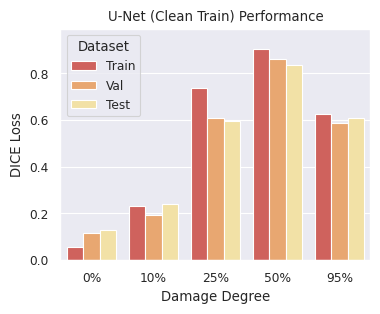

In [19]:
# Bar plot that shit.
clean_performance_data = pd.read_csv('./models/unet/saves/2024-03-14-(17-17-31)/damage-performance.csv', header=None).rename(columns={0 : 'Damage Degree', 1 : 'Train', 2 : 'Val', 3 : 'Test'})
clean_performance_data['Damage Degree'] = clean_performance_data['Damage Degree'].apply(lambda x : f'{int(100 * x)}%')

# Melt the dataframe into long format.
# Ignore the 95% damage case -- the model is clearly statically guessing.
clean_performance_melted = pd.melt(clean_performance_data, id_vars='Damage Degree', var_name='Dataset', value_name='DICE Loss')
clean_performance_melted

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=clean_performance_melted, x='Damage Degree', y='DICE Loss', hue='Dataset', ax=ax)
ax.set_ylim(0,.99)

ax.set_title('U-Net (Clean Train) Performance')

plt.savefig('./misc-figures/clean-unet-performance-degradation-with-damage.pdf', bbox_inches='tight')

In [23]:
hopfield_layer = build_hopfield_restoration_block(
    image_size=128,
    patch_size=4,
    channels=3,
    embed_dim=768,
    stored_patterns=2**14
).to('cuda')
hopfield_layer.load_state_dict(torch.load('./models/hopfield-pre-processing/saves/2024-03-10-(21-33-09)/model-state-dict'))

hopfield_model = SegmentationModel()
hopfield_model.load_state_dict(torch.load('./models/hopfield-unet/saves/2024-03-15-(02-26-15)/model-state-dict.pt'))

<All keys matched successfully>

In [ ]:
# Performance of hopfield model on different degrees of damage.
damage_degrees = [.0, .10, .25, .50, .95]

batch_size = 8
for damage_degree in tqdm(damage_degrees):
    # Train.
    train_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Training_Input',
        target_path='ISIC2018_Task1_Training_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        train_performance = test(hopfield_model, train_dataloader, hopfield_layer)
    else:
        train_performance = test(hopfield_model, train_dataloader)
    
    del train_dataset
    del train_dataloader
    
    # Validation.
    val_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Validation_Input',
        target_path='ISIC2018_Task1_Validation_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        val_performance = test(hopfield_model, val_dataloader, hopfield_layer)
    else:
        val_performance = test(hopfield_model, val_dataloader)
    
    del val_dataset
    del val_dataloader
    
    # Test.
    test_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Test_Input',
        target_path='ISIC2018_Task1_Test_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        test_performance = test(hopfield_model, test_dataloader, hopfield_layer)
    else:
        test_performance = test(hopfield_model, test_dataloader)
    
    del test_dataset
    del test_dataloader
    
    # Write stats to file.
    with open(f'./models/hopfield-unet/saves/2024-03-15-(02-26-15)/damage-performance.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([damage_degree, train_performance, val_performance, test_performance])

    print(f'Damage degree - {damage_degree}: train - {train_performance}, val - {val_performance}, test - {test_performance}')

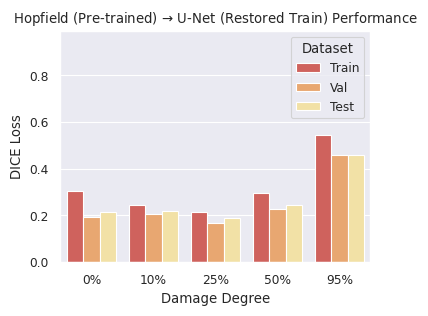

In [18]:
# Bar plot that shit.
hopfield_performance_data = pd.read_csv('./models/hopfield-unet/saves/2024-03-15-(02-26-15)/damage-performance.csv', header=None).rename(columns={0 : 'Damage Degree', 1 : 'Train', 2 : 'Val', 3 : 'Test'})
hopfield_performance_data['Damage Degree'] = hopfield_performance_data['Damage Degree'].apply(lambda x : f'{int(100 * x)}%')

# Melt the dataframe into long format.
# Ignore the 95% damage case -- the model is clearly statically guessing.
hopfield_performance_melted = pd.melt(hopfield_performance_data, id_vars='Damage Degree', var_name='Dataset', value_name='DICE Loss')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=hopfield_performance_melted, x='Damage Degree', y='DICE Loss', hue='Dataset', ax=ax)
ax.set_ylim(0,.99)

ax.set_title('Hopfield (Pre-trained) $\\to$ U-Net (Restored Train) Performance')

plt.savefig('./misc-figures/hopfield-unet-performance-degradation-with-damage.pdf', bbox_inches='tight')

In [11]:
clean_model = SegmentationModel()
clean_model.load_state_dict(torch.load('./models/unet/saves/2024-03-14-(17-17-31)/model-state-dict.pt'))

<All keys matched successfully>

In [ ]:
# Performance of clean model with Hopfield pre-processing on different degrees of damage.
damage_degrees = [.0, .10, .25, .50, .95]

batch_size = 8
for damage_degree in tqdm(damage_degrees):
    # Train.
    train_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Training_Input',
        target_path='ISIC2018_Task1_Training_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        train_performance = test(clean_model, train_dataloader, hopfield_layer)
    else:
        train_performance = test(clean_model, train_dataloader)
    
    del train_dataset
    del train_dataloader
    
    # Validation.
    val_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Validation_Input',
        target_path='ISIC2018_Task1_Validation_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        val_performance = test(clean_model, val_dataloader, hopfield_layer)
    else:
        val_performance = test(clean_model, val_dataloader)
    
    del val_dataset
    del val_dataloader
    
    # Test.
    test_dataset = ISICDataset(
        root_path=data_directory,
        input_path='ISIC2018_Task1-2_Test_Input',
        target_path='ISIC2018_Task1_Test_GroundTruth',
        transform=True,
        image_width=128, image_height=128,
        damage=damage_degree!=0,
        damage_degree=damage_degree
    )
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))
    if damage_degree != 0:
        test_performance = test(clean_model, test_dataloader, hopfield_layer)
    else:
        test_performance = test(clean_model, test_dataloader)
    
    del test_dataset
    del test_dataloader
    
    # Write stats to file.
    with open(f'./models/unet/saves/2024-03-14-(17-17-31)/damage-performance-with-hopfield-preprocessing.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([damage_degree, train_performance, val_performance, test_performance])

    print(f'Damage degree - {damage_degree}: train - {train_performance}, val - {val_performance}, test - {test_performance}')

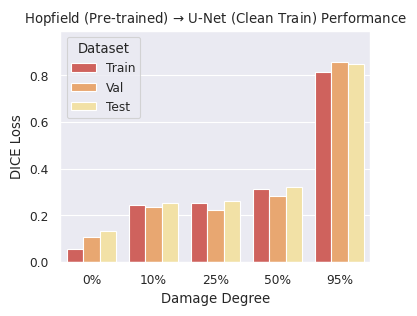

In [20]:
# Bar plot that shit.
hopfield_clean_performance_data = pd.read_csv('./models/unet/saves/2024-03-14-(17-17-31)/damage-performance-with-hopfield-preprocessing.csv', header=None).rename(columns={0 : 'Damage Degree', 1 : 'Train', 2 : 'Val', 3 : 'Test'})
hopfield_clean_performance_data['Damage Degree'] = hopfield_clean_performance_data['Damage Degree'].apply(lambda x : f'{int(100 * x)}%')

# Melt the dataframe into long format.
# Ignore the 95% damage case -- the model is clearly statically guessing.
hopfield_clean_performance_melted = pd.melt(hopfield_clean_performance_data, id_vars='Damage Degree', var_name='Dataset', value_name='DICE Loss')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=hopfield_clean_performance_melted, x='Damage Degree', y='DICE Loss', hue='Dataset', ax=ax)
ax.set_ylim(0,.99)

ax.set_title('Hopfield (Pre-trained) $\\to$ U-Net (Clean Train) Performance')

plt.savefig('./misc-figures/hopfield-(preprocess-only)-unet-performance-degradation-with-damage.pdf', bbox_inches='tight')

In [40]:
sns.color_palette('magma', n_colors=10)

[(0.069764, 0.049726, 0.193735),
 (0.198177, 0.063862, 0.404009),
 (0.347636, 0.082946, 0.494121),
 (0.494258, 0.141462, 0.507988),
 (0.639216, 0.189921, 0.49415),
 (0.786212, 0.241514, 0.450184),
 (0.913354, 0.330052, 0.382563),
 (0.979645, 0.491014, 0.367783),
 (0.996341, 0.660969, 0.45116),
 (0.995131, 0.827052, 0.585701)]

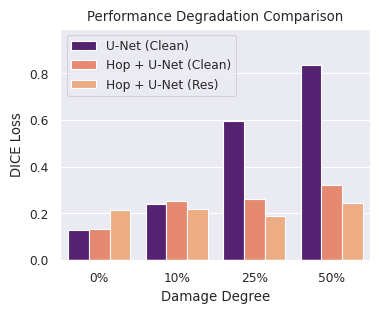

In [68]:
# Bar plot that shit, together. Test performance only.
clean_performance_data['Model'] = ['U-Net (Clean)'] * len(clean_performance_data)
hopfield_clean_performance_data['Model'] = ['Hop + U-Net (Clean)'] * len(hopfield_clean_performance_data)
hopfield_performance_data['Model'] = ['Hop + U-Net (Res)'] * len(hopfield_performance_data)

all_data = pd.concat([clean_performance_data, hopfield_clean_performance_data, hopfield_performance_data])
all_data = all_data[all_data['Damage Degree'] != '95%']

colours = sns.color_palette('magma', n_colors=10)
custom_palette = [colours[2], colours[-3], colours[-2]]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.barplot(data=all_data, x='Damage Degree', y='Test', hue='Model', ax=ax, palette=custom_palette)
ax.set_ylim(0,.99)

ax.set_title('Performance Degradation Comparison')
ax.set_ylabel('DICE Loss')
ax.legend(title='')

plt.savefig('./misc-figures/all-models-performance-degradation-with-damage.pdf', bbox_inches='tight')

In [39]:
all_data[['Damage Degree', 'Model', 'Test']].reset_index()

,index,Damage Degree,Model,Test
0,0,0%,U-Net (Clean),0.128993
1,1,10%,U-Net (Clean),0.239400
2,2,25%,U-Net (Clean),0.593534
3,3,50%,U-Net (Clean),0.836515
4,4,95%,U-Net (Clean),0.608842
5,0,0%,Hop + U-Net (Clean),0.130549
6,1,10%,Hop + U-Net (Clean),0.254473
7,2,25%,Hop + U-Net (Clean),0.261994
8,3,50%,Hop + U-Net (Clean),0.321528
9,4,95%,Hop + U-Net (Clean),0.849565


In [9]:
1 - (.457048 / .608842)

0.24931591447370582

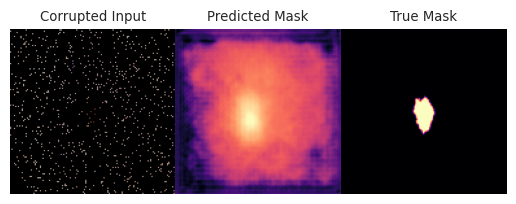

In [80]:
# Let's have a wee looksie at a 95% damage segmentation. You know, for fun.
test_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Test_Input',
    target_path='ISIC2018_Task1_Test_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.95
)

cmap = 'magma'
# Break apart the sample and move to device.
example_input, example_target = test_dataset[4]
example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
example_target = example_target.to('cuda')
reconstructed_input = hopfield_layer(example_input)
example_output, _ = hopfield_model(reconstructed_input, example_target)

# Show them.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')

ax1.set_title('Corrupted Input')
ax2.set_title('Predicted Mask')
ax3.set_title('True Mask')

plt.savefig('./models/hopfield-unet/saves/2024-03-15-(02-26-15)/segmentation-example-(damage=95).pdf', bbox_inches='tight')

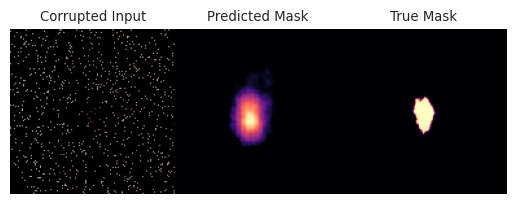

In [87]:
# Thresholding the above.
def threshold_tensor(tensor, threshold):
  mask = tensor > threshold
  return torch.where(mask, tensor, torch.tensor(threshold))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
ax2.imshow(threshold_tensor(example_output[0], threshold=7).detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')

ax1.set_title('Corrupted Input')
ax2.set_title('Predicted Mask')
ax3.set_title('True Mask')

plt.savefig('./models/hopfield-unet/saves/2024-03-15-(02-26-15)/segmentation-example-(damage=95)-(with-threshold).pdf', bbox_inches='tight')

Text(0.5, 1.0, 'True Mask')

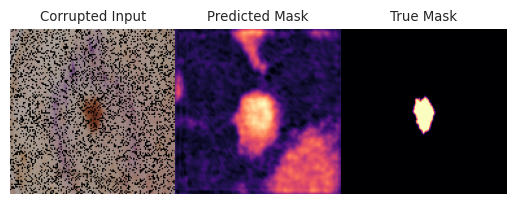

In [12]:
# Let's have a wee looksie at a 25% damage segmentation. You know, for fun.
test_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Test_Input',
    target_path='ISIC2018_Task1_Test_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.25
)

cmap = 'magma'
# Break apart the sample and move to device.
example_input, example_target = test_dataset[4]
example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
example_target = example_target.to('cuda')
example_output, _ = clean_model(example_input, example_target)

# Show them.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')

ax1.set_title('Corrupted Input')
ax2.set_title('Predicted Mask')
ax3.set_title('True Mask')

Text(0.5, 1.0, 'True Mask')

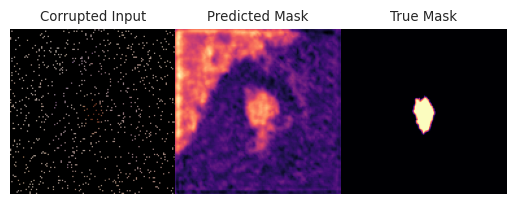

In [13]:
# Let's have a wee looksie at a 95% damage segmentation. You know, for fun.
test_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Test_Input',
    target_path='ISIC2018_Task1_Test_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=True,
    damage_degree=.95
)

cmap = 'magma'
# Break apart the sample and move to device.
example_input, example_target = test_dataset[4]
example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
example_target = example_target.to('cuda')
example_output, _ = clean_model(example_input, example_target)

# Show them.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')

ax1.set_title('Corrupted Input')
ax2.set_title('Predicted Mask')
ax3.set_title('True Mask')

In [21]:
clean_input.shape

torch.Size([3, 128, 128])

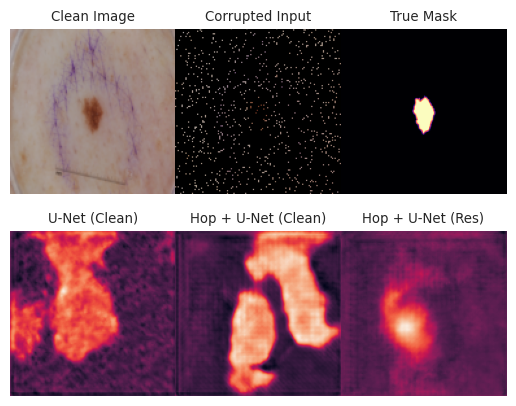

In [35]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, gridspec_kw={'wspace': 0, 'hspace': 0.2})

test_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Test_Input',
    target_path='ISIC2018_Task1_Test_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
    damage=False,
    damage_degree=.95
)

cmap = 'magma'
clean_input, target = test_dataset[4]
damaged_input = test_dataset.damage_image(clean_input)
damaged_input = damaged_input.reshape(1, 3, 128, 128).to('cuda')
target = target.to('cuda')

ax1.imshow(clean_input.detach().cpu().permute(1, 2, 0))
ax2.imshow(damaged_input[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(target[0].detach().cpu(), cmap=cmap)

clean_output, _ = clean_model(damaged_input, target)
restored_input = hopfield_layer(damaged_input)
clean_hopfield_output, _ = clean_model(restored_input, target)
restored_hopfield_output, _ = hopfield_model(restored_input, target)

ax4.imshow(clean_output[0].detach().cpu().permute(1, 2, 0))
ax5.imshow(clean_hopfield_output[0].detach().cpu().permute(1, 2, 0))
ax6.imshow(restored_hopfield_output[0].detach().cpu().permute(1, 2, 0))

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')
ax4.axis('off')
ax4.axis('tight')
ax4.axis('image')
ax5.axis('off')
ax5.axis('tight')
ax5.axis('image')
ax6.axis('off')
ax6.axis('tight')
ax6.axis('image')

ax1.set_title('Clean Image')
ax2.set_title('Corrupted Input')
ax3.set_title('True Mask')

ax4.set_title('U-Net (Clean)')
ax5.set_title('Hop + U-Net (Clean)')
ax6.set_title('Hop + U-Net (Res)')

plt.savefig('./misc-figures/example-segmentation-comparison-all-models-(damage=95).pdf', bbox_inches='tight')

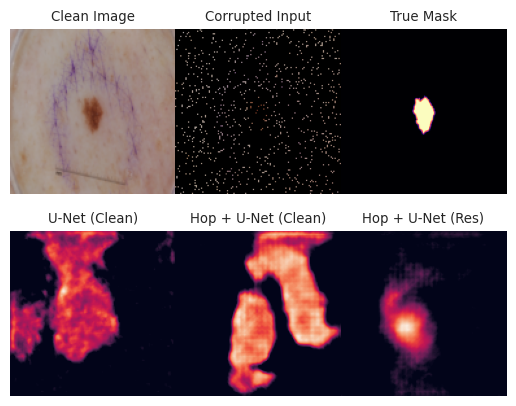

In [44]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, gridspec_kw={'wspace': 0, 'hspace': 0.2})

# Thresholding the above.
def threshold_tensor(tensor, threshold):
  mask = tensor > threshold
  return torch.where(mask, tensor, torch.tensor(threshold))

ax1.imshow(clean_input.detach().cpu().permute(1, 2, 0))
ax2.imshow(damaged_input[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
ax3.imshow(target[0].detach().cpu(), cmap=cmap)

t = -5
ax4.imshow(threshold_tensor(clean_output[0], threshold=t).detach().cpu().permute(1, 2, 0))
ax5.imshow(threshold_tensor(clean_hopfield_output[0], threshold=t).detach().cpu().permute(1, 2, 0))
ax6.imshow(threshold_tensor(restored_hopfield_output[0], threshold=t).detach().cpu().permute(1, 2, 0))

# Beautify.
ax1.axis('off')
ax1.axis('tight')
ax1.axis('image')
ax2.axis('off')
ax2.axis('tight')
ax2.axis('image')
ax3.axis('off')
ax3.axis('tight')
ax3.axis('image')
ax4.axis('off')
ax4.axis('tight')
ax4.axis('image')
ax5.axis('off')
ax5.axis('tight')
ax5.axis('image')
ax6.axis('off')
ax6.axis('tight')
ax6.axis('image')

ax1.set_title('Clean Image')
ax2.set_title('Corrupted Input')
ax3.set_title('True Mask')

ax4.set_title('U-Net (Clean)')
ax5.set_title('Hop + U-Net (Clean)')
ax6.set_title('Hop + U-Net (Res)')

plt.savefig('./misc-figures/example-segmentation-comparison-all-models-(damage=95)-(thresholding).pdf', bbox_inches='tight')